<a href="https://colab.research.google.com/github/VinhNguyen313/LIGO-and-Gravitational-Waves-Project/blob/master/Vinh_Nguyen_%E2%80%93_Gravitational_Wave_Detection_%E2%80%93_Code_Appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Vinh Nguyen – Klein Oak High School

Advisor: Dr. Eric Myers – State University of New York, New Paltz

---

This Google Colaboratory is to be accompanied with the paper titled  

***Gravitational Wave Detection: Event GW170814 and the performance of matched filtering and χ2-consistency testing in the presence of Gaussian noise, non-Gaussianly distributed noise, and transient glitches*** 

---

The full paper can be found [here](https://github.com/VinhNguyen313/LIGO-and-Gravitational-Waves-Project).


\* Code was partially referenced from the [Gravitational Wave Open Science Center](https://www.gw-openscience.org/)

# Initialization


In [ ]:
# Install modules, for Google Colab use only
! pip install -q 'gwpy==1.0.1'
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

In [ ]:
#Import necessary libraries
import gwpy
from gwpy.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.filter import  highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
%matplotlib inline

#Matched filtering and $\chi^2$-consistency testing

## Noise generation / glitch extraction


In [ ]:
#Define important parameters

dt = 1/4096     #sampling period in seconds
fs = int(1/dt)  #sampling frequency in Hertz
m1 = 30         #Inspiral mass 1 in Solar Masses
m2 = 23         #Inspiral mass 2 in Solar Masses
fl = 14         #Initial frequency of inspiral for template generation

Fetched 1 URLs from www.gw-openscience.org for [1176952094 .. 1176952144))
Reading data... [Done]


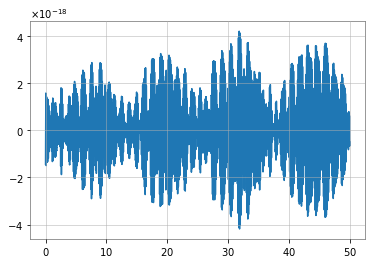

In [ ]:
#Query for glitch data from GWOSC and plot the time series

gps = 1176952119                    #GPS time of maximum amplitude of the glitch
segment = (int(gps)-25,int(gps)+25) #Time segment of glitch – 25 seconds before and after the time of max amplitude

noise = TimeSeries.fetch_open_data('L1', *segment, verbose=True) #Query raw data from GWOSC at 4096 Hz, indicate detector location
noise = noise.to_pycbc()                                         #Cast type from GWPy TimeSeries to PyCBC TimeSeries for more functionality
plt.plot(np.linspace(0,50,fs*50),noise)                          #Plot the noise as a function of time

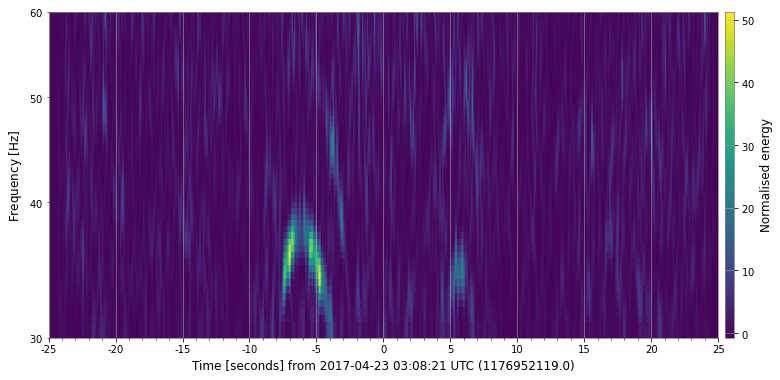

In [ ]:
#Generate Noise Q-transformed Spectrogram

noise = TimeSeries(noise, sample_rate = 4096, t0=gps-25) #Cast type to GwPy
hq = noise.q_transform(frange=(30, 70), qrange=(40, 20)) #Apply a Q-transform

#Plot the Q-transformed spectrogam
plot = hq.plot()
ax = plot.gca()
ax.set_ylim(30, 60)
ax.set_yscale('log')
ax.set_epoch(gps)
ax.colorbar(label="Normalised energy")

noise = noise.to_pycbc()                                 #Re-cast type from GWPy TimeSeries to PyCBC TimeSeries for more functionality

In [ ]:
#Generate Gaussian noise
#UNCOMMENT FOR GAUSSIAN NOISE
#
#noise = TimeSeries(np.random.normal(0, 1,fs*50), sample_rate = 4096, t0=gps-25)*10**-21
#noise = noise.to_pycbc()



#Generate Laplacian noise
#UNCOMMENT FOR LAPLACIAN NOISE
#
#b = 1 #Define scale parameter for the Laplace distribution
#noise = TimeSeries(np.random.laplace(0, b,fs*50), sample_rate = 4096, t0=gps-25)*10**-21
#noise = noise.to_pycbc()

## Template creation and injection

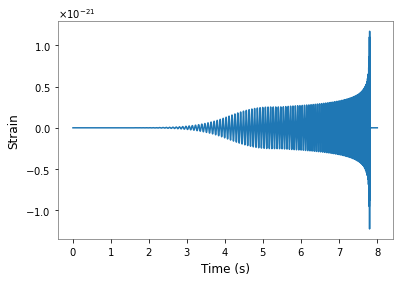

In [ ]:
hp, _ = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1.0/4096,
                         f_lower= fl,
                         distance = 500, 
                        start_time = gps-25)      #Generate waveform template using PyCBC

template = hp

#Plot template as a funciton of time
plt.plot(np.linspace(0,len(template)/fs,len(template)),template) 
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid()
plt.show()

In [ ]:
time = np.linspace(0,int(50),int(50*fs))


#Condition template for injection
template.resize(len(noise))
template.roll(35*fs)
template.start_time=gps-25

#Perform software injection
data = noise + template
data = highpass(data, 15)     #High pass the data with a threshold of 15Hz.
print(type(data))
data.start_time = int(gps)-25

<class 'pycbc.types.timeseries.TimeSeries'>


## Extracting using a matched filter

In [ ]:
#Estimate the power spectral density function

#Approximate the psd using 4 seconds of data with the Welch method
psd = data.psd(4)

#Interpolate PSD function with a low frequency cutoff of 15Hz since data was highpassed above
psd = interpolate(psd, data.delta_f)
psd = inverse_spectrum_truncation(psd, 4 * data.sample_rate,
                                 low_frequency_cutoff=15)

In [ ]:
#Regenerate and condition template to be used for matched filtering
matchedtemplate, _ = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1.0/4096,
                         f_lower= fl,
                         distance = 500, 
                        start_time = gps-25)
matchedtemplate.resize(len(data))

We found a signal at 35.0s with SNR 27.63262005861594


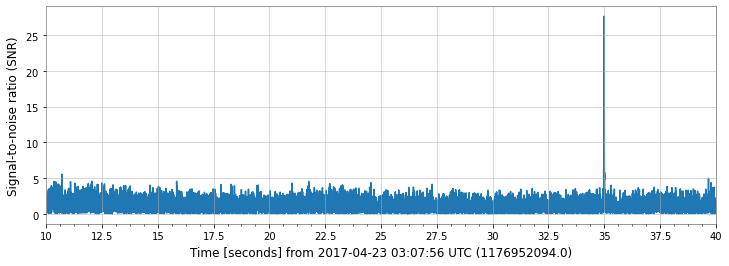

In [ ]:
#Perform matched filtering on data

snr = matched_filter(matchedtemplate, data,
                     psd=psd,low_frequency_cutoff=20)

snr = snr.crop(10, 10)                    #Crop 10 seconds of SNR on both ends       
snrts = TimeSeries.from_pycbc(snr).abs()  #Take the absolute value of the original complex-valued SNR

#Plot SNR as a function of time
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(gps-15, gps+15)
ax.set_epoch(gps-25)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
plot.show()

#Search for and print out peak SNR and it's associated time location
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a signal at {}s with SNR {}".format(time-gps+25, 
                                                    abs(snrp)))

## $\chi^2$-consistency Testing

In [ ]:
#Apply the chi-sqare test
chisq = {}
nbins = 40
chisq = power_chisq(matchedtemplate, data, nbins, psd, low_frequency_cutoff=10.0)
chisq = chisq.crop(10, 10)      #Crop the SNR 10 seconds on both ends

#Normalize chi-squared staistic
dof = nbins * 2 - 2             #Calculate degree of freedom
chisq /= dof                    #Normalize the statistic

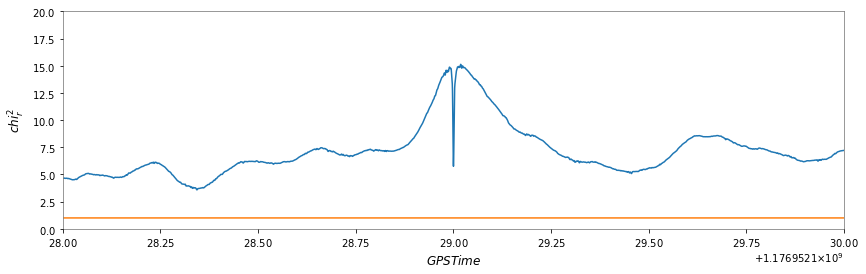

In [ ]:
#Plot reduced chi-squared statistic as a function of time

plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq)
plt.plot(chisq.sample_times,np.full(len(chisq), fill_value= 1, dtype = int))
plt.grid()
plt.ylim(0, 20)
plt.xlim(gps-25+34,gps-25+36)
plt.ylabel('$chi^2_r$')
plt.xlabel('$GPS Time$')
plt.show()

We found a signal at 35.0s with reweighted SNR 27.63262005861594


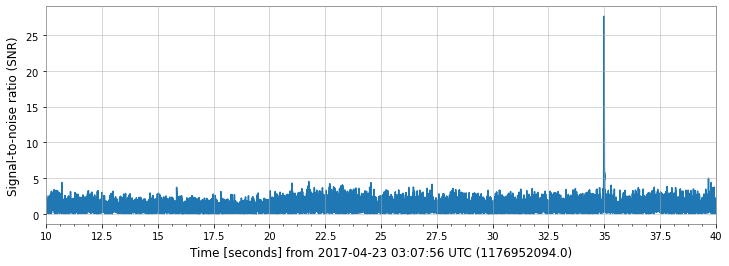

In [ ]:
import numpy
# The reweighted SNR rho-hat value is named "newsnr" here

nsnr = newsnr(snrts,chisq.crop(10,10)) #Re-weigh the SNR

#Plot the reweighted SNR as a function of time
nsnr = TimeSeries(nsnr, sample_rate = 4096, t0=gps-15)
plot = nsnr.plot()
ax = plot.gca()
ax.set_xlim(gps-15, gps+15)
#ax.set_ylim(0, 20)
ax.set_epoch(gps-25)
ax.set_ylabel('Signal-to-noise ratio (SNR)')

#Search for and print out peak reweighted SNR and it's associated time location
nsnr = nsnr.to_pycbc()
peak = abs(nsnr).numpy().argmax()
nsnrp = nsnr[peak]
time = nsnr.sample_times[peak]

print("We found a signal at {}s with reweighted SNR {}".format(time-gps+25, 
                                                    abs(nsnrp)))

plot.show()